# Homework 7
**Alex Smith**<br>
July 2, 2016<br>
MIDS261 - Machine Learning at Scale<br>
Professor Shanahan<br>
Due: July 10, 2016

***
### Useful resources
The following resources were particularly useful.
- [Wikipedia: Longest Path Problem](https://en.wikipedia.org/wiki/Longest_path_problem)

### Libraries
The following libraries must be installed before running the below code. They can all be installed through [Pip](https://github.com/pypa/pip).
- [Scikit Learn](http://scikit-learn.org/stable/)
- [Numpy](http://www.numpy.org/)
- [Regular Expression](https://docs.python.org/2/library/re.html)
- [Pretty Table](https://pypi.python.org/pypi/PrettyTable)
- [Random](https://docs.python.org/2/library/random.html)
- [Datetime](https://docs.python.org/2/library/datetime.html)
- [Matplotlib](http://matplotlib.org/)
- [MRJob](https://pythonhosted.org/mrjob/)
- [Pandas](http://pandas.pydata.org/)

***
## General Description
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

***
## Undirected toy network dataset

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

***
## Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

***
## HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To prove you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

#### Set up the graph
First we set up the graph by creating the data structure that assigns to each node:
- the distance from the source
- the path from each node
- the edges from that node
- the status of that node as:
    - 'Q': enqueue
    - 'U': unvisited
    - 'V': visited

In [40]:
%%writefile MRgraphset.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphset(MRJob):
    
    # set the source node
    source = None
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphset, self).configure_options()
        self.add_passthrough_option("--indx", type='int', default=1)

    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                        mapper=self.mapper)] 
    
    
    # the mapper init sets the source node
    def mapper_init(self):
        self.source = self.options.indx        
    
    
    # the mapper takes each line and 
    # outputs the node, its path to 
    # the source, its distance to the 
    # source, it's linked nodes, and its
    # status as visited
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        
        # initalize distance, path, and
        # status
        dist = 0
        path = []
        status = None
        
        # if this is the source node
        if node == self.source:
            
            # set the distance to 0
            # the path to none and 
            # the status to 'Q' for
            # queue
            dist = 0
            path = []
            status = 'Q'
            
        # else if this is not the source node
        else:
            
            # set the distance to a max
            # value, the path to null, and 
            # the status to 'U' for unvisited
            dist = sys.maxint
            path = []
            status = 'U'
            
        # for each node yield the initial
        # graph state
        key = node
        value = (edges,dist,path,status)
        yield key,value
    

if __name__ == '__main__':
    MRgraphset.run()

Overwriting MRgraphset.py


In [41]:
# run the MRJob class to create initial graph
# that we'll iterate through
!python MRgraphset.py undirected_toy.txt --indx=1 --quiet > undirected_ready.txt
!cat undirected_ready.txt

1	[{"2": 1, "5": 1}, 0, [], "Q"]
2	[{"1": 1, "3": 1, "5": 1, "4": 1}, 9223372036854775807, [], "U"]
3	[{"2": 1, "4": 1}, 9223372036854775807, [], "U"]
4	[{"3": 1, "2": 1, "5": 1}, 9223372036854775807, [], "U"]
5	[{"1": 1, "2": 1, "4": 1}, 9223372036854775807, [], "U"]


In [51]:
# run the MRJob class to create initial graph
# that we'll iterate through
!python MRgraphset.py directed_toy.txt --indx=1 --quiet > directed_ready.txt
!cat directed_ready.txt

1	[{"2": 1, "6": 1}, 0, [], "Q"]
2	[{"1": 1, "3": 1, "4": 1}, 9223372036854775807, [], "U"]
3	[{"2": 1, "4": 1}, 9223372036854775807, [], "U"]
4	[{"2": 1, "5": 1}, 9223372036854775807, [], "U"]
5	[{"1": 1, "2": 1, "4": 1}, 9223372036854775807, [], "U"]


In [58]:
%%writefile MRshortest.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import copy
  
class MRshortest(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper=self.mapper,\
                       reducer=self.reducer)] 
    
    
    # the mapper takes each line and 
    # performs an action based on the
    # status of the node
    def mapper(self, _, line):
        
        # split the line into the node
        # and the payload that has so
        # much information
        line = line.strip().split('\t')
        node = int(line[0])
        payload = ast.literal_eval(line[1])

        # split up the payload into its
        # component parts
        outlinks = payload[0]
        dist = int(payload[1])
        path = payload[2]
        status = payload[3]
        
        # if we're not dealing with a node in
        # status 'Q'
        if status == 'Q':
            
            # the distance to the outlinks is
            # the distance to the current node
            # plus 1 
            edge_dist = dist + 1
            
            # we don't know the outlinks for the 
            # outlinks we're about to emit
            edge_outlinks = {}
            
            # we append to the existing path
            # the node that brought us here
            edge_path = copy.deepcopy(path)
            edge_path.append(node)
            
            # the status for the next edge is
            # Q because we will look at that
            # next
            edge_status = 'Q'
            
            # loop through the outedges
            for edge in outlinks:
                
                # set the key, value pair
                # we emit for each queued up
                # node
                edge_key = edge
                edge_payload = (edge_outlinks,\
                                edge_dist,\
                                edge_path,\
                                edge_status)
                
                # emit the next in line for
                # queueing
                yield int(edge_key), edge_payload
                
            # set a new status for this node,
            # visited
            new_status = 'V'
            
            # set the key,value pair for this
            # original node
            new_key = node
            new_value = (outlinks,dist,path,new_status)
            yield int(new_key),new_value

        # else if the node is not in queue
        # status, then simply yield it as is
        else:
            key = node
            value = (outlinks,dist,path,status)
            yield int(key),value
            
        
    # our reducer merges the outputs 
    # from nodes of various statuses
    # and yields a single line for each
    # node
    def reducer(self, node, payloads):

        # initalize storage variables
        # that will keep track of the 
        # everything for all the nodes
        node = node
        new_outlinks = []
        new_dists = []
        new_paths = []
        statuses = []

        # initalize the final variables
        # that we'll use to output
        final_outlinks = {}
        final_dist = None
        final_path = None
        final_status = None

        # loop through the payloads
        for payload in payloads:

            # gather all the information
            # from the payload
            outlinks = payload[0]
            dist = payload[1]
            path = payload[2]
            status = payload[3]

            # update the variables for
            # each node
            new_outlinks.append(outlinks)
            new_dists.append(dist)
            new_paths.append(path)
            statuses.append(status)

        # look at the status to determine
        # what to do; let's start with if
        # we have a 'V'
        if 'V' in statuses:

            # get the index of the "v" status
            index = statuses.index('V')

            # set the final variables based
            # on the node we've already 
            # visited
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
        
        # else if we have a 'Q'
        elif 'Q' in statuses:
            
            # find the unvisited and queued
            # indices
            q_index = statuses.index('Q')
            
            # only add outlinks if we have 'U'
            # otherwise, we should just add
            # blank outlinks as we are going
            # outside of our graph     
            if 'U' in statuses:

                u_index = statuses.index('U')

                # get the final outlinks from the 
                # unvisited node
                final_outlinks = new_outlinks[u_index]

            # else put up blank outlinks
            else: 
                final_outlinks = {}

            

            # get the distance and the path and
            # the status from 'queued' node
            final_dist = new_dists[q_index]
            final_path = new_paths[q_index]
            final_status = statuses[q_index]
            
        # else, we must have only an unvisited
        # node, and we'll take all the information
        # from the unvisited node
        else:
            
            # set the index based on the
            # unvisited node
            index = statuses.index('U')
            
            # get the final variables all from
            # the unvisited node
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
            
            
        # set the key value that we'll be
        # outputting for each node, only one for
        # each node
        key = node
        value = (final_outlinks,\
                 final_dist,\
                 final_path,\
                 final_status)
        
        # yield the key-value pair
        yield key,value
    

if __name__ == '__main__':
    MRshortest.run()

Overwriting MRshortest.py


In [59]:
# unit test for a single go
!python MRshortest.py undirected_ready.txt --quiet > temp.txt
!cat temp.txt

1	[{"2": 1, "5": 1}, 0, [], "V"]
2	[{"1": 1, "3": 1, "5": 1, "4": 1}, 1, [1], "Q"]
3	[{"2": 1, "4": 1}, 9223372036854775807, [], "U"]
4	[{"3": 1, "2": 1, "5": 1}, 9223372036854775807, [], "U"]
5	[{"1": 1, "2": 1, "4": 1}, 1, [1], "Q"]


In [28]:
# keep unit testing one iteration at a time
!python MRshortest.py temp.txt --quiet > temp2.txt
!cat temp2.txt

1	[{"2": 1, "5": 1}, 0, [], "V"]
2	[{"1": 1, "3": 1, "5": 1, "4": 1}, 1, [1], "V"]
3	[{"2": 1, "4": 1}, 2, [1, 2], "Q"]
4	[{"3": 1, "2": 1, "5": 1}, 2, [1, 2], "Q"]
5	[{"1": 1, "2": 1, "4": 1}, 1, [1], "V"]


In [29]:
# keep unit testing one iteration at a time
!python MRshortest.py temp2.txt --quiet > temp3.txt
!cat temp3.txt

1	[{"2": 1, "5": 1}, 0, [], "V"]
2	[{"1": 1, "3": 1, "5": 1, "4": 1}, 1, [1], "V"]
3	[{"2": 1, "4": 1}, 2, [1, 2], "V"]
4	[{"3": 1, "2": 1, "5": 1}, 2, [1, 2], "V"]
5	[{"1": 1, "2": 1, "4": 1}, 1, [1], "V"]


### Develop a driver and run on both the directed and undirected toy files
We've now shown how we can iterate through the toy graphs. We'll now do so with a driver.

#### Prepare the data

In [39]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRgraphset import MRgraphset

###
# prepare the undirected data
###

# set the data that we're going to pull
mr_job1 = MRgraphset(args=['undirected_toy.txt',\
                           '--indx=1']) 

# create the runner and run it
with mr_job1.make_runner() as runner:
    runner.run()
    
    # create the file we will output to
    with open('undirected_ready.txt','w') as myfile:
        
        # run the runner and send each
        # line to the file
        for line in runner.stream_output():
            
            # grab the key,value
            key,value =  mr_job1.parse_output_line(line)
            
            # write to the file
            info = str(key) + "\t" + str(value) + "\n"
            myfile.write(info)

# show the output
!echo Undirected Ready
!cat undirected_ready.txt
            
###
# prepare the directed data
###

# set the data that we're going to pull
mr_job1 = MRgraphset(args=['directed_toy.txt',\
                           '--indx=1']) 

# create the runner and run it
with mr_job1.make_runner() as runner:
    runner.run()
    
    # create the file we will output to
    with open('directed_ready.txt','w') as myfile:
        
        # run the runner and send each
        # line to the file
        for line in runner.stream_output():
            
            # grab the key,value
            key,value =  mr_job1.parse_output_line(line)
            
            # write to the file
            info = str(key) + "\t" + str(value) + "\n"
            myfile.write(info)

# show the output            
!echo
!echo Directed Ready
!cat directed_ready.txt

Undirected Ready
1	[{'2': 1, '5': 1}, 0, [], 'Q']
2	[{'1': 1, '3': 1, '5': 1, '4': 1}, 9223372036854775807, [], 'U']
3	[{'2': 1, '4': 1}, 9223372036854775807, [], 'U']
4	[{'3': 1, '2': 1, '5': 1}, 9223372036854775807, [], 'U']
5	[{'1': 1, '2': 1, '4': 1}, 9223372036854775807, [], 'U']

Directed Ready
1	[{'2': 1, '6': 1}, 0, [], 'Q']
2	[{'1': 1, '3': 1, '4': 1}, 9223372036854775807, [], 'U']
3	[{'2': 1, '4': 1}, 9223372036854775807, [], 'U']
4	[{'2': 1, '5': 1}, 9223372036854775807, [], 'U']
5	[{'1': 1, '2': 1, '4': 1}, 9223372036854775807, [], 'U']


#### Step through the UNDIRECTED prepared data

In [48]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortest import MRshortest

# copy the prepared file into a 
# temporary file that we'll keep
# overwriting
!cp undirected_ready.txt undirected_temp.txt

###
# prepare the undirected data
###

# set the data that we're going to pull
mr_job = MRshortest(args=['undirected_temp.txt']) 

# set the q_count equal to 1 and 
# keep running the runner until
# we have nothing in queue
q_count = 1
while (q_count > 0):
    
    # set the q_count to 0
    q_count = 0
    
    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()

        # create the file we will output to
        with open('undirected_temp.txt','w') as myfile:

            # run the runner and send each
            # line to the file
            for line in runner.stream_output():

                # grab the key,value
                key,value =  mr_job.parse_output_line(line)
                
                # grab the status
                status = value[3]
                
                # if it's a q, increment the 
                # q_count
                if status == 'Q':
                    q_count = q_count + 1
                
                # write to the file
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)

# check out the output file, everything
# should be visited
!cat undirected_temp.txt

1	[{'2': 1, '5': 1}, 0, [], 'V']
2	[{'1': 1, '3': 1, '5': 1, '4': 1}, 1, [1], 'V']
3	[{'2': 1, '4': 1}, 2, [1, 2], 'V']
4	[{'3': 1, '2': 1, '5': 1}, 2, [1, 2], 'V']
5	[{'1': 1, '2': 1, '4': 1}, 1, [1], 'V']


#### Step through the DIRECTED preprared data

In [60]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortest import MRshortest

# copy the prepared file into a 
# temporary file that we'll keep
# overwriting
!cp directed_ready.txt directed_temp.txt

###
# prepare the undirected data
###

# set the data that we're going to pull
mr_job = MRshortest(args=['directed_temp.txt']) 

# set the q_count equal to 1 and 
# keep running the runner until
# we have nothing in queue
q_count = 1
while (q_count > 0):
    
    # set the q_count to 0
    q_count = 0
    
    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()

        # create the file we will output to
        with open('directed_temp.txt','w') as myfile:

            # run the runner and send each
            # line to the file
            for line in runner.stream_output():

                # grab the key,value
                key,value =  mr_job.parse_output_line(line)
                
                # grab the status
                status = value[3]
                
                # if it's a q, increment the 
                # q_count
                if status == 'Q':
                    q_count = q_count + 1
                
                # write to the file
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)

# check out the output file, everything
# should be visited
!cat directed_temp.txt

1	[{'2': 1, '6': 1}, 0, [], 'V']
2	[{'1': 1, '3': 1, '4': 1}, 1, [1], 'V']
3	[{'2': 1, '4': 1}, 2, [1, 2], 'V']
4	[{'2': 1, '5': 1}, 2, [1, 2], 'V']
5	[{'1': 1, '2': 1, '4': 1}, 3, [1, 2, 4], 'V']
6	[{}, 1, [1], 'V']


***
## HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

- number of nodes, 
- number links,
- or the average degree (i.e., the average number of links per node),
- etc...

As you develop your code, please be sure to run it locally first (though not on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

### LOCAL: Number of nodes, links, and average degree

In [58]:
%%writefile MRexplore.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRexplore(MRJob):
    
    # set some global variables
    total_nodes = 0
    total_edges = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can take the total edges over the
        # total nodes
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper=self.mapper,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final)]        
    
    
    # the mapper outputs for each node
    # a node count and the number of links
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        num_edges = len(edges)
        
        # yield the node with count 1
        # and the number of edges
        yield 'Node',1
        yield 'Edges',num_edges
        
    
    # the reducer sums across the nodes and edges 
    # and updates the global variables
    def reducer(self, label, counts):
        
        # sum the counts
        sum_counts = sum(counts)
        
        # if we have the nodes, set the
        # total nodes
        if label == 'Node':
            self.total_nodes = sum_counts
            
        # else set the total edges
        else:
            self.total_edges = sum_counts
            
    
    # the reducer final takes the total nodes and 
    # edges and divides to get the average
    def reducer_final(self):
        
        # yield the edges and nodes
        yield "Total Nodes:", self.total_nodes
        yield "Total Edges:", self.total_edges
        
        # calculate the average
        avg_edges = float(self.total_edges) / float(self.total_nodes)
        yield "Average Degrees:", avg_edges


if __name__ == '__main__':
    MRexplore.run()

Overwriting MRexplore.py


In [59]:
# run the exploratory data anlaysis on
# our data
!echo Our exploratory analysis yields:
!python MRexplore.py synNet/synNet.txt --quiet

Our exploratory analysis yields:
"Total Nodes:"	8271
"Total Edges:"	61134
"Average Degrees:"	7.391367428364164


### CLOUD: Number of nodes, links, and average degree

In [60]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160709.230736.149005
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160709.230736.149005/files/...
j-2CVJI0SC449S9


In [63]:
# upload the NLTK file to S3
!aws s3 cp synNet/synNet.txt s3://aks-w261-hw7/synNet.txt

upload: synNet/synNet.txt to s3://aks-w261-hw7/synNet.txt


In [64]:
# run the program with the cluster we 
# just spun up
!echo Our exploratory analysis yields:
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-1
!python MRexplore.py -r emr s3://aks-w261-hw7/synNet.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/out_7-1 \

Our exploratory analysis yields:
Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRexplore.Alex.20160709.232520.874079
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRexplore.Alex.20160709.232520.874079/files/...
Adding our job to existing cluster j-2CVJI0SC449S9
Waiting for step 1 of 1 (s-3SC4NKHAOBYXB) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40770/cluster
  RUNNING for 4.7s
  RUNNING for 37.4s
     5.0% complete
  RUNNING for 68.6s
   100.0% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-3SC4NKHAOBYXB on ec2-54-153-88-129.us-west-1.compute.amazonaws.com...
  Parsing step log: ssh://ec2-54-153-88-129.us-west-1.compute.amazonaws.com/mnt/var/log/hadoop/steps/s-3SC4

### LOCAL: Degrees distribution

In [70]:
%%writefile MRdegdist.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRdegdist(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can easily take a single file and 
        # load it into matplot lib later
        # if we find this approach doesn't
        # scale, we can always up this without
        # affecting the job's functionality
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper=self.mapper,\
                       combiner=self.reducer,\
                       reducer=self.reducer)]        
    
    
    # the mapper outputs for each node
    # athe number of edges and 1
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        num_edges = len(edges)
        
        # yield the node with count 1
        # and the number of edges
        yield num_edges,1
        
    
    # the reducer calculates how many
    # counts we have for each edge
    def reducer(self, num_edges, counts):
        
        # yield the number of edges and
        # the total number of nodes that
        # have that many edges
        yield num_edges, sum(counts)


if __name__ == '__main__':
    MRdegdist.run()

Writing MRdegdist.py


In [72]:
# run the degree distribution anlaysis on
# our data
!echo Our degree distribution yields \(sample\):
!python MRdegdist.py synNet/synNet.txt --quiet > synNet/degDist.txt
!head synNet/degDist.txt

Our degree distribution yields (sample):
1	1421
10	254
11	200
110	2
117	1
12	158
127	1
13	135
131	1
14	111


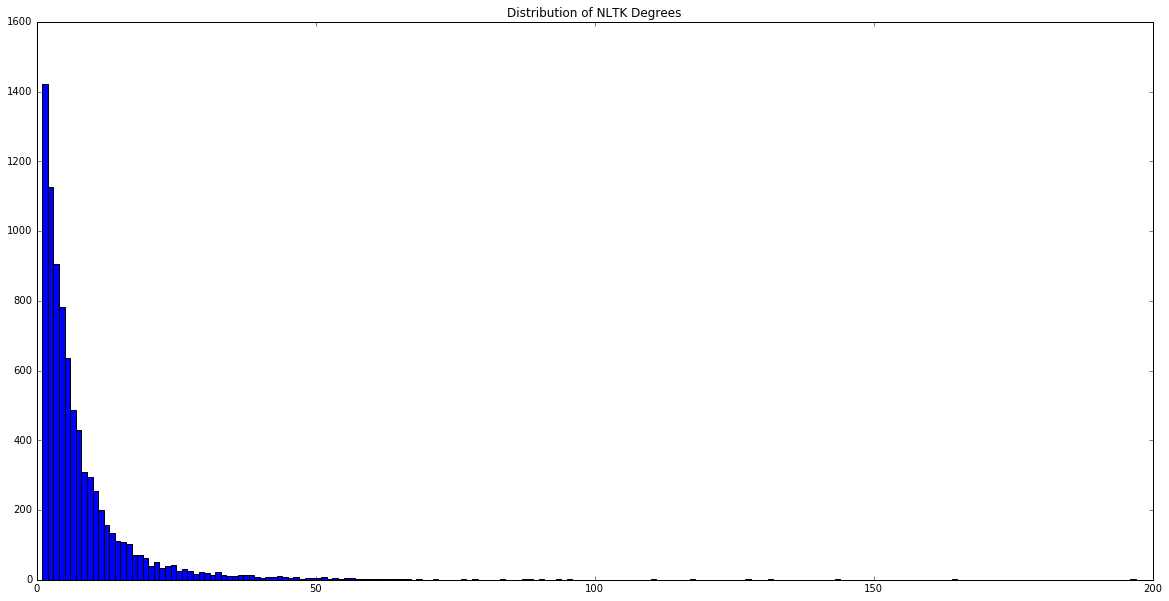

In [74]:
%matplotlib inline

# import pandas and matplotlib to load
# the data and plot the histogram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read in the data as a data frame
data = pd.read_table('synNet/degDist.txt',header=None)
data_count = data.iloc[:,1]
data_lengt = data.iloc[:,0]

# gives histogram bars a width
width = 1.0 

# plot the histogram
plt.figure(figsize=(20,10))
plt.bar(data_lengt,data_count, width, color='b')
plt.title("Distribution of NLTK Degrees")
plt.show()

Yes, this does appear to follow a power law. The vast majority of data points are clustered around a single point with a very long tail.

### CLOUD: Degrees distribution

In [65]:
# run the program with the cluster we 
# just spun up
!echo Our degree distribution on the cloud completes successfully:
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-1
!python MRdegdist.py -r emr s3://aks-w261-hw7/synNet.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/out_7-1 \
    --no-output

Our degree distribution on the cloud completes successfully:
delete: s3://aks-w261-hw7/out_7-1/_SUCCESS
delete: s3://aks-w261-hw7/out_7-1/part-00000     
Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRdegdist.Alex.20160709.233257.566325
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRdegdist.Alex.20160709.233257.566325/files/...
Adding our job to existing cluster j-2CVJI0SC449S9
Waiting for step 1 of 1 (s-1FOIGLZ70VL4I) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40770/cluster
  RUNNING for 11.4s
   100.0% complete
  RUNNING for 43.7s
     5.0% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-1FOIGLZ70VL4I on ec2-54-153-88-129.us-west-1.compute.amazonaws.com...
  Par

***
## HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Prove your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though not on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

### LOCAL: Prepare the data
We set the source node and develop the adjacency list.

In [75]:
%%writefile MRgraphset.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphset(MRJob):
    
    # set the source node
    source = None
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphset, self).configure_options()
        self.add_passthrough_option("--indx", type='int', default=1)

    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                        mapper=self.mapper)] 
    
    
    # the mapper init sets the source node
    def mapper_init(self):
        self.source = self.options.indx        
    
    
    # the mapper takes each line and 
    # outputs the node, its path to 
    # the source, its distance to the 
    # source, it's linked nodes, and its
    # status as visited
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        
        # initalize distance, path, and
        # status
        dist = 0
        path = []
        status = None
        
        # if this is the source node
        if node == self.source:
            
            # set the distance to 0
            # the path to none and 
            # the status to 'Q' for
            # queue
            dist = 0
            path = []
            status = 'Q'
            
        # else if this is not the source node
        else:
            
            # set the distance to a max
            # value, the path to null, and 
            # the status to 'U' for unvisited
            dist = sys.maxint
            path = []
            status = 'U'
            
        # for each node yield the initial
        # graph state
        key = node
        value = (edges,dist,path,status)
        yield key,value
    

if __name__ == '__main__':
    MRgraphset.run()

Overwriting MRgraphset.py


In [78]:
# run the MRJob class to create initial graph
# that we'll iterate through
!python MRgraphset.py synNet/synNet.txt --indx=7827 --quiet > synNet/synNet_ready.txt
!head synNet/synNet_ready.txt

1	[{"3": 1, "2": 1, "4": 1}, 9223372036854775807, [], "U"]
2	[{"1": 1, "3": 1, "310": 1, "4": 1, "311": 1}, 9223372036854775807, [], "U"]
3	[{"1": 1, "2": 1, "4": 1}, 9223372036854775807, [], "U"]
4	[{"1": 1, "3": 1, "2": 1, "311": 1}, 9223372036854775807, [], "U"]
5	[{"6": 1}, 9223372036854775807, [], "U"]
6	[{"5": 1}, 9223372036854775807, [], "U"]
7	[{"9": 1, "8": 1}, 9223372036854775807, [], "U"]
8	[{"9": 1, "7": 1}, 9223372036854775807, [], "U"]
9	[{"8": 1, "124": 1, "7": 1, "1316": 1}, 9223372036854775807, [], "U"]
10	[{"11": 1, "13": 1, "12": 1, "15": 1, "14": 1, "17": 1, "16": 1}, 9223372036854775807, [], "U"]


### LOCAL: Step through our graph

In [77]:
%%writefile MRshortest.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import copy
  
class MRshortest(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper=self.mapper,\
                       reducer=self.reducer)] 
    
    
    # the mapper takes each line and 
    # performs an action based on the
    # status of the node
    def mapper(self, _, line):
        
        # split the line into the node
        # and the payload that has so
        # much information
        line = line.strip().split('\t')
        node = int(line[0])
        payload = ast.literal_eval(line[1])

        # split up the payload into its
        # component parts
        outlinks = payload[0]
        dist = int(payload[1])
        path = payload[2]
        status = payload[3]
        
        # if we're not dealing with a node in
        # status 'Q'
        if status == 'Q':
            
            # the distance to the outlinks is
            # the distance to the current node
            # plus 1 
            edge_dist = dist + 1
            
            # we don't know the outlinks for the 
            # outlinks we're about to emit
            edge_outlinks = {}
            
            # we append to the existing path
            # the node that brought us here
            edge_path = copy.deepcopy(path)
            edge_path.append(node)
            
            # the status for the next edge is
            # Q because we will look at that
            # next
            edge_status = 'Q'
            
            # loop through the outedges
            for edge in outlinks:
                
                # set the key, value pair
                # we emit for each queued up
                # node
                edge_key = edge
                edge_payload = (edge_outlinks,\
                                edge_dist,\
                                edge_path,\
                                edge_status)
                
                # emit the next in line for
                # queueing
                yield int(edge_key), edge_payload
                
            # set a new status for this node,
            # visited
            new_status = 'V'
            
            # set the key,value pair for this
            # original node
            new_key = node
            new_value = (outlinks,dist,path,new_status)
            yield int(new_key),new_value

        # else if the node is not in queue
        # status, then simply yield it as is
        else:
            key = node
            value = (outlinks,dist,path,status)
            yield int(key),value
            
        
    # our reducer merges the outputs 
    # from nodes of various statuses
    # and yields a single line for each
    # node
    def reducer(self, node, payloads):

        # initalize storage variables
        # that will keep track of the 
        # everything for all the nodes
        node = node
        new_outlinks = []
        new_dists = []
        new_paths = []
        statuses = []

        # initalize the final variables
        # that we'll use to output
        final_outlinks = {}
        final_dist = None
        final_path = None
        final_status = None

        # loop through the payloads
        for payload in payloads:

            # gather all the information
            # from the payload
            outlinks = payload[0]
            dist = payload[1]
            path = payload[2]
            status = payload[3]

            # update the variables for
            # each node
            new_outlinks.append(outlinks)
            new_dists.append(dist)
            new_paths.append(path)
            statuses.append(status)

        # look at the status to determine
        # what to do; let's start with if
        # we have a 'V'
        if 'V' in statuses:

            # get the index of the "v" status
            index = statuses.index('V')

            # set the final variables based
            # on the node we've already 
            # visited
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
        
        # else if we have a 'Q'
        elif 'Q' in statuses:
            
            # find the unvisited and queued
            # indices
            q_index = statuses.index('Q')
            
            # only add outlinks if we have 'U'
            # otherwise, we should just add
            # blank outlinks as we are going
            # outside of our graph     
            if 'U' in statuses:

                u_index = statuses.index('U')

                # get the final outlinks from the 
                # unvisited node
                final_outlinks = new_outlinks[u_index]

            # else put up blank outlinks
            else: 
                final_outlinks = {}

            

            # get the distance and the path and
            # the status from 'queued' node
            final_dist = new_dists[q_index]
            final_path = new_paths[q_index]
            final_status = statuses[q_index]
            
        # else, we must have only an unvisited
        # node, and we'll take all the information
        # from the unvisited node
        else:
            
            # set the index based on the
            # unvisited node
            index = statuses.index('U')
            
            # get the final variables all from
            # the unvisited node
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
            
            
        # set the key value that we'll be
        # outputting for each node, only one for
        # each node
        key = node
        value = (final_outlinks,\
                 final_dist,\
                 final_path,\
                 final_status)
        
        # yield the key-value pair
        yield key,value
    

if __name__ == '__main__':
    MRshortest.run()

Overwriting MRshortest.py


In [7]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortest import MRshortest

# copy the prepared file into a 
# temporary file that we'll keep
# overwriting
!cp synNet/synNet_ready.txt synNet/synNet_temp.txt

# set the data that we're going to pull
mr_job = MRshortest(args=['synNet/synNet_temp.txt']) 

# set the index of interest and initalize
# values to hold the distance and the path
INTEREST = 536
dist = None
path = None

# set the q_count equal to 1 and 
# keep running the runner until
# we have nothing in queue
q_count = 1
while (q_count > 0):
    
    # set the q_count to 0
    q_count = 0
    
    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()

        # create the file we will output to
        with open('synNet/synNet_temp.txt','w') as myfile:

            # run the runner and send each
            # line to the file
            for line in runner.stream_output():

                # grab the key,value
                key,value =  mr_job.parse_output_line(line)
                
                # grab the status
                status = value[3]
                
                # if it's a q, increment the 
                # q_count
                if status == 'Q':
                    q_count = q_count + 1
                
                # if we've got to our one of interest
                if key == INTEREST:
                    dist = value[1]
                    path = value[2]
                
                # write to the file
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)

# print out the path and the distance
# to the source node
print "Distance for node of interest from source:"
print dist
print "Path to reach node of interest from source:"
print path
print "\n"
print "*~*~*~*~*"
print "\n"

# write the path to a file for later joining
with open('synNet/path.txt','w') as myfile:
    myfile.write(str(path))

# check out the output file, everything
# should be visited, unvisited nodes should
# be unconnected to the source node
!echo Sample of our graph
!head synNet/synNet_temp.txt

Distance for node of interest from source:
3
Path to reach node of interest from source:
[7827, 1426, 1668]


*~*~*~*~*


Sample of our graph
1	[{'3': 1, '2': 1, '4': 1}, 7, [7827, 1426, 3480, 1030, 586, 310, 2], 'V']
10	[{'11': 1, '13': 1, '12': 1, '15': 1, '14': 1, '17': 1, '16': 1}, 4, [7827, 1426, 1685, 17], 'V']
100	[{'3827': 1, '2872': 1, '2871': 1, '2870': 1, '2873': 1, '2875': 1, '2874': 1, '3122': 1, '2443': 1, '617': 1, '4647': 1, '2441': 1, '3722': 1, '5550': 1, '5336': 1, '93': 1, '92': 1, '3720': 1, '360': 1}, 5, [7827, 1426, 1038, 3833, 93], 'V']
1000	[{'997': 1, '999': 1, '1004': 1, '1003': 1, '1002': 1, '1001': 1}, 9223372036854775807, [], 'U']
1001	[{'997': 1, '999': 1, '998': 1, '1000': 1}, 9223372036854775807, [], 'U']
1002	[{'997': 1, '999': 1, '998': 1, '1000': 1}, 9223372036854775807, [], 'U']
1003	[{'2095': 1, '997': 1, '999': 1, '998': 1, '1000': 1}, 9223372036854775807, [], 'U']
1004	[{'997': 1, '3352': 1, '999': 1, '998': 1, '1000': 1}, 9223372036854775807, []

### LOCAL: Join the indices we found with names
We perform a memory backed join where we hold the smaller dataset in memory and run the larger data set through. If we get a match, we yield that out. We don't need a reducer.

In [54]:
%%writefile MRjoinInd.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRjoinInd(MRJob):
    
    # store the indices of interest
    path = []
    path_labels = [0]*len(path)
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can make a single file with all the 
        # indices linked up.
        # if we find this approach doesn't
        # scale, we can always up this without
        # affecting the job's functionality
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper_init=self.mapper_init,\
                       mapper=self.mapper,\
                       reducer_init=self.mapper_init,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final)]        
    
    
    # the mapper_init loads the list of indices
    # of interest into memory
    def mapper_init(self):
        
        # open the path file, that contains
        # the list of indices of interest
        with open('path.txt','r') as myfile:
            
            # read the line in the file
            for line in myfile.readlines():
                self.path = ast.literal_eval(line)
                
        # geneate an empty array for the labels
        self.path_labels = [0]*len(self.path)
            
    
    # the mapper checks each line of the total
    # index with matching labels and emits
    # only those that match with our stored
    # list in the path
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        label = line[0]
        index = int(line[1])

        # check to see if this is in our
        # path, and if so, yield it out
        if index in self.path:
            yield index,label

    
    # the reducer updates the path labels list
    def reducer(self, index, labels):

        # grab the index 
        path_index = self.path.index(index)

        # place the label in the 
        # path labels place in the appropriate
        # place
        self.path_labels[path_index] = list(labels)[0]
        
        
    # the reducer final yields the completed
    # list for the path
    def reducer_final(self):
        
        # loop through each element in the 
        # path and yield it with its label
        for i,index in enumerate(self.path):
            yield self.path[i],self.path_labels[i]

if __name__ == '__main__':
    MRjoinInd.run()

Overwriting MRjoinInd.py


In [57]:
# run the MRJob class to find the path
# between our nodes in words
!python MRjoinInd.py synNet/indices.txt --file=synNet/path.txt --quiet > synNet/path_labelled.txt

!echo The shortest path between "walk" \(index=7827\) and "make" \(index=536\):
!cat synNet/path_labelled.txt

The shortest path between walk (index=7827) and make (index=536):
7827	"walk"
1426	"pass"
1668	"Give"


### CLOUD: Prepare our data

In [85]:
# run the program with the cluster we 
# just spun up
!echo We prepare the data in the cloud
!aws s3 rm --recursive s3://aks-w261-hw7/synNet_ready --quiet
!python MRgraphset.py -r emr s3://aks-w261-hw7/synNet.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/synNet_ready \
    --no-output \
    --indx=7827

We prepare the data in the cloud
Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRgraphset.Alex.20160710.011827.926015
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRgraphset.Alex.20160710.011827.926015/files/...
Adding our job to existing cluster j-2CVJI0SC449S9
Waiting for step 1 of 1 (s-247QQOS83QDKW) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40770/cluster
  RUNNING for 5.7s
   100.0% complete
  RUNNING for 38.0s
     5.0% complete
  RUNNING for 69.8s
   100.0% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-247QQOS83QDKW on ec2-54-153-88-129.us-west-1.compute.amazonaws.com...
  Parsing step log: ssh://ec2-54-153-88-129.us-west-1.compute.amazonaws.com/mnt/var/lo

### CLOUD: Step through the data

In [92]:
# copy the prepared file into a 
# temporary file that we'll keep
# overwriting
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-2/input --quiet
!aws s3 cp --recursive s3://aks-w261-hw7/synNet_ready s3://aks-w261-hw7/out_7-2/input --quiet

# remove anything in the output
# directory
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-2/output --quiet
    
print "S3 preparation complete"

S3 preparation complete


In [93]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortest import MRshortest

# clear the output to make space for the 
# next iteration
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-2/output --quiet
        
# set the data that we're going to pull
mr_job = MRshortest(args=['s3://aks-w261-hw7/out_7-2/input', \
                          '-r','emr',\
                          '--cluster-id=j-2CVJI0SC449S9', \
                          '--aws-region=us-west-1', \
                          '--output-dir=s3://aks-w261-hw7/out_7-2/output', \
                          '--no-output'\
                         ]) 

# set the index of interest and initalize
# values to hold the distance and the path
INTEREST = 536
dist = None
path = None

# set the q_count equal to 1 and 
# keep running the runner until
# we have nothing in queue
q_count = 1
while (q_count > 0):
    
    # set the q_count to 0
    q_count = 0
    
    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()

        # create the file we will output to
        with open('synNet/synNet_temp.txt','w') as myfile:

            # run the runner and send each
            # line to the file
            for line in runner.stream_output():

                # grab the key,value
                key,value =  mr_job.parse_output_line(line)
                
                # grab the status
                status = value[3]
                
                # if it's a q, increment the 
                # q_count
                if status == 'Q':
                    q_count = q_count + 1
                
                # if we've got to our one of interest
                if key == INTEREST:
                    dist = value[1]
                    path = value[2]
                
                # write to the file
                info = str(key) + "\t" + str(value) + "\n"
                myfile.write(info)
                
        # remove the existing files from aws and 
        # upload this temporary file
        !aws s3 rm --recursive s3://aks-w261-hw7/out_7-2/input --quiet
        !aws s3 cp synNet/synNet_temp.txt s3://aks-w261-hw7/out_7-2/input --quiet
        
        # clear the output to make space for the 
        # next iteration
        !aws s3 rm --recursive s3://aks-w261-hw7/out_7-2/output --quiet

# print out the path and the distance
# to the source node
print "Distance for node of interest from source:"
print dist
print "Path to reach node of interest from source:"
print path
print "\n"
print "*~*~*~*~*"
print "\n"

# write the path to a file for later joining
with open('synNet/path.txt','w') as myfile:
    myfile.write(str(path))

# check out the output file, everything
# should be visited, unvisited nodes should
# be unconnected to the source node
!echo Sample of our graph
!head synNet/synNet_temp.txt

Distance for node of interest from source:
3
Path to reach node of interest from source:
[7827, 1426, 1685]


*~*~*~*~*


Sample of our graph
1001	[{'997': 1, '999': 1, '998': 1, '1000': 1}, 9223372036854775807, [], 'U']
1010	[{'6065': 1, '6066': 1, '7760': 1, '1009': 1, '1008': 1, '1007': 1}, 9223372036854775807, [], 'U']
104	[{'108': 1, '109': 1, '111': 1, '110': 1, '113': 1, '112': 1, '106': 1, '107': 1, '105': 1}, 6, [7827, 1426, 1706, 4439, 782, 109], 'V']
1079	[{'1425': 1, '1078': 1, '1075': 1, '1590': 1, '4203': 1, '2158': 1, '2163': 1}, 4, [7827, 1426, 2160, 2163], 'V']
1088	[{'1087': 1, '3834': 1, '1084': 1, '2884': 1, '4338': 1, '3835': 1, '4383': 1, '610': 1, '5315': 1, '5314': 1, '3336': 1, '96': 1}, 4, [7827, 4655, 1092, 3834], 'V']
1097	[{'3834': 1, '1094': 1, '1096': 1, '1084': 1, '1091': 1, '1095': 1, '2297': 1, '1093': 1, '1098': 1, '1099': 1, '581': 1, '2294': 1, '2406': 1, '2407': 1, '1102': 1, '2414': 1, '2400': 1, '2402': 1, '96': 1, '6164': 1, '6166': 1}, 4, [7827

### CLOUD: Join the indices we found with names

In [94]:
# upload the path file to S3 and the indices file
!aws s3 cp synNet/path.txt s3://aks-w261-hw7/nltk/path.txt --quiet
!aws s3 cp synNet/indices.txt s3://aks-w261-hw7/nltk/indices.txt --quiet
print "Files successfully uploaded"

Files successfully uploaded


In [97]:
# run the program with the cluster we 
# just spun up
!echo We join our findings with the labels
!aws s3 rm --recursive s3://aks-w261-hw7/joins_7-2
!python MRjoinInd.py -r emr s3://aks-w261-hw7/nltk/indices.txt \
    --file=s3://aks-w261-hw7/nltk/path.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/joins_7-2 \
    --no-output

We join our findings with the labels
Using configs in /Users/Alex/.mrjob.conf
Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRjoinInd.Alex.20160710.023114.065927
Copying local files to s3://mrjob-f8c316b67324528f/tmp/MRjoinInd.Alex.20160710.023114.065927/files/...
Adding our job to existing cluster j-2CVJI0SC449S9
Waiting for step 1 of 1 (s-T2MYBYP4IQ4Y) to complete...
  Opening ssh tunnel to resource manager...
  Connect to resource manager at: http://localhost:40770/cluster
  RUNNING for 11.9s
   100.0% complete
  RUNNING for 44.3s
     7.8% complete
  RUNNING for 75.3s
   100.0% complete
  COMPLETED
Attempting to fetch counters from logs...
Looking for step log in /mnt/var/log/hadoop/steps/s-T2MYBYP4IQ4Y on ec2-54-153-88-129.us-west-1.compute.amazonaws.com...
  Parsing step log: ssh://ec2-54-153-88-129.us-west-1.compute.amazonaws.com/mnt/var/l

In [98]:
# bring the file done from the cloud and 
# show our results
!echo Our shortest path is:
!aws s3 cp s3://aks-w261-hw7/joins_7-2/part-00000 synNet/aws_path_labelled.txt
!cat synNet/aws_path_labelled.txt

Our shortest path is:
download: s3://aks-w261-hw7/joins_7-2/part-00000 to synNet/aws_path_labelled.txt
7827	"walk"
1426	"pass"
1685	"Given"


## HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

Systems test on directed_toy.txt completed above in 7.0

### Find the number of nodes, number of edges, and average degrees

In [99]:
%%writefile MRexplore.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRexplore(MRJob):
    
    # set some global variables
    total_nodes = 0
    total_edges = 0
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can take the total edges over the
        # total nodes
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper=self.mapper,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final)]        
    
    
    # the mapper outputs for each node
    # a node count and the number of links
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        num_edges = len(edges)
        
        # yield the node with count 1
        # and the number of edges
        yield 'Node',1
        yield 'Edges',num_edges
        
    
    # the reducer sums across the nodes and edges 
    # and updates the global variables
    def reducer(self, label, counts):
        
        # sum the counts
        sum_counts = sum(counts)
        
        # if we have the nodes, set the
        # total nodes
        if label == 'Node':
            self.total_nodes = sum_counts
            
        # else set the total edges
        else:
            self.total_edges = sum_counts
            
    
    # the reducer final takes the total nodes and 
    # edges and divides to get the average
    def reducer_final(self):
        
        # yield the edges and nodes
        yield "Total Nodes:", self.total_nodes
        yield "Total Edges:", self.total_edges
        
        # calculate the average
        avg_edges = float(self.total_edges) / float(self.total_nodes)
        yield "Average Degrees:", avg_edges


if __name__ == '__main__':
    MRexplore.run()

Overwriting MRexplore.py


In [100]:
# run the program with the cluster we 
# just spun up
!echo Our exploratory analysis in the cloud is complete
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-3
!python MRexplore.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/out_7-3 \
    --no-output \
    --quiet

Our exploratory analysis in the cloud is complete


In [101]:
# store the file locally
!aws s3 cp s3://aks-w261-hw7/out_7-3/part-00000 wiki/eda.txt
!echo EDA for Wikipedia
!cat wiki/eda.txt

download: s3://aks-w261-hw7/out_7-3/part-00000 to wiki/eda.txt
EDA for Wikipedia
"Total Nodes:"	5781290
"Total Edges:"	142114057
"Average Degrees:"	24.58172086160701


### Calculate the degree distribution for the file

In [102]:
%%writefile MRdegdist.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRdegdist(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can easily take a single file and 
        # load it into matplot lib later
        # if we find this approach doesn't
        # scale, we can always up this without
        # affecting the job's functionality
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper=self.mapper,\
                       combiner=self.reducer,\
                       reducer=self.reducer)]        
    
    
    # the mapper outputs for each node
    # athe number of edges and 1
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        num_edges = len(edges)
        
        # yield the node with count 1
        # and the number of edges
        yield num_edges,1
        
    
    # the reducer calculates how many
    # counts we have for each edge
    def reducer(self, num_edges, counts):
        
        # yield the number of edges and
        # the total number of nodes that
        # have that many edges
        yield num_edges, sum(counts)


if __name__ == '__main__':
    MRdegdist.run()

Overwriting MRdegdist.py


In [103]:
# run the program with the cluster we 
# just spun up
!echo Our degree distribution on the cloud completes successfully:
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-3
!python MRdegdist.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --cluster-id=j-2CVJI0SC449S9 \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/out_7-3 \
    --no-output \
    --quiet

Our degree distribution on the cloud completes successfully:
delete: s3://aks-w261-hw7/out_7-3/_SUCCESS
delete: s3://aks-w261-hw7/out_7-3/part-00000     


In [104]:
# store the file locally
!aws s3 cp s3://aks-w261-hw7/out_7-3/part-00000 wiki/degreeDist.txt

download: s3://aks-w261-hw7/out_7-3/part-00000 to wiki/degreeDist.txt


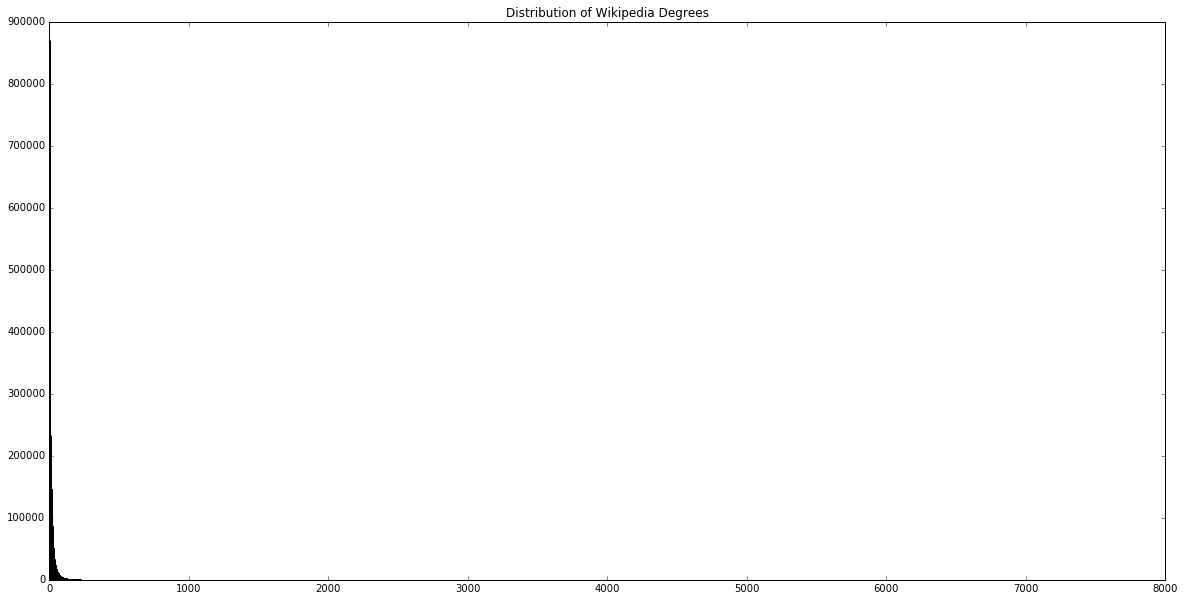

In [106]:
%matplotlib inline

# import pandas and matplotlib to load
# the data and plot the histogram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read in the data as a data frame
data = pd.read_table('wiki/degreeDist.txt',header=None)
data_count = data.iloc[:,1]
data_lengt = data.iloc[:,0]

# gives histogram bars a width
width = 1.0 

# plot the histogram
plt.figure(figsize=(20,10))
plt.bar(data_lengt,data_count, width, color='b')
plt.title("Distribution of Wikipedia Degrees")
plt.show()

***
## HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.

###  <span style="color:violet">SCALABILITY!!!</span>
So, our previous approaches worked for the NLTK data because it wasn't that large. However, copying data back and forth from local disk to cloud is highly inefficient. We also don't want to see each line to check for a stopping condition. Instead, let's use MRJob's counters. To test this out, we rewrite our program to use counters and use the counters to tell us when to stop. Instead of using runners, we wrap magic commands within python while loops. 

### MRJob revised class to step through graph

In [15]:
%%writefile MRshortCount.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import copy
  
class MRshortCount(MRJob):
    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper=self.mapper,\
                       reducer=self.reducer)] 
    
    
    # the mapper takes each line and 
    # performs an action based on the
    # status of the node
    def mapper(self, _, line):
        
        # split the line into the node
        # and the payload that has so
        # much information
        line = line.strip().split('\t')
        node = int(line[0])
        payload = ast.literal_eval(line[1])

        # split up the payload into its
        # component parts
        outlinks = payload[0]
        dist = int(payload[1])
        path = payload[2]
        status = payload[3]
        
        # if we're not dealing with a node in
        # status 'Q'
        if status == 'Q':
            
            # the distance to the outlinks is
            # the distance to the current node
            # plus 1 
            edge_dist = dist + 1
            
            # we don't know the outlinks for the 
            # outlinks we're about to emit
            edge_outlinks = {}
            
            # we append to the existing path
            # the node that brought us here
            edge_path = copy.deepcopy(path)
            edge_path.append(node)
            
            # the status for the next edge is
            # Q because we will look at that
            # next
            edge_status = 'Q'
            
            # loop through the outedges
            for edge in outlinks:
                
                # set the key, value pair
                # we emit for each queued up
                # node
                edge_key = edge
                edge_payload = (edge_outlinks,\
                                edge_dist,\
                                edge_path,\
                                edge_status)
                
                # emit the next in line for
                # queueing
                yield int(edge_key), edge_payload
                
            # set a new status for this node,
            # visited
            new_status = 'V'
            
            # set the key,value pair for this
            # original node
            new_key = node
            new_value = (outlinks,dist,path,new_status)
            yield int(new_key),new_value

        # else if the node is not in queue
        # status, then simply yield it as is
        else:
            key = node
            value = (outlinks,dist,path,status)
            yield int(key),value
            
        
    # our reducer merges the outputs 
    # from nodes of various statuses
    # and yields a single line for each
    # node
    def reducer(self, node, payloads):

        # initalize storage variables
        # that will keep track of the 
        # everything for all the nodes
        node = node
        new_outlinks = []
        new_dists = []
        new_paths = []
        statuses = []

        # initalize the final variables
        # that we'll use to output
        final_outlinks = {}
        final_dist = None
        final_path = None
        final_status = None

        # loop through the payloads
        for payload in payloads:

            # gather all the information
            # from the payload
            outlinks = payload[0]
            dist = payload[1]
            path = payload[2]
            status = payload[3]

            # update the variables for
            # each node
            new_outlinks.append(outlinks)
            new_dists.append(dist)
            new_paths.append(path)
            statuses.append(status)

        # look at the status to determine
        # what to do; let's start with if
        # we have a 'V'
        if 'V' in statuses:

            # get the index of the "v" status
            index = statuses.index('V')

            # set the final variables based
            # on the node we've already 
            # visited
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
        
        # else if we have a 'Q'
        elif 'Q' in statuses:
            
            # increment the counter for the number
            # of q's we've got
            self.increment_counter('Nodes', 'enqueue', 1)
            
            # find the unvisited and queued
            # indices
            q_index = statuses.index('Q')
            
            # only add outlinks if we have 'U'
            # otherwise, we should just add
            # blank outlinks as we are going
            # outside of our graph     
            if 'U' in statuses:

                u_index = statuses.index('U')

                # get the final outlinks from the 
                # unvisited node
                final_outlinks = new_outlinks[u_index]

            # else put up blank outlinks
            else: 
                final_outlinks = {}

            

            # get the distance and the path and
            # the status from 'queued' node
            final_dist = new_dists[q_index]
            final_path = new_paths[q_index]
            final_status = statuses[q_index]
            
        # else, we must have only an unvisited
        # node, and we'll take all the information
        # from the unvisited node
        else:
            
            # set the index based on the
            # unvisited node
            index = statuses.index('U')
            
            # get the final variables all from
            # the unvisited node
            final_outlinks = new_outlinks[index]
            final_dist = new_dists[index]
            final_path = new_paths[index]
            final_status = statuses[index]
            
            
        # set the key value that we'll be
        # outputting for each node, only one for
        # each node
        key = node
        value = (final_outlinks,\
                 final_dist,\
                 final_path,\
                 final_status)
        
        # yield the key-value pair
        yield key,value
    

if __name__ == '__main__':
    MRshortCount.run()

Overwriting MRshortCount.py


### Unit test locally
We figure out this freaky counter things by unit testing on our directed toy network. 

In [4]:
!python MRshortCount.py directed_ready.txt

Using configs in /Users/Alex/.mrjob.conf
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRshortCount.Alex.20160710.144059.553049
Running step 1 of 1...
Counters: 1
	Nodes
		enqueue=2
Streaming final output from /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRshortCount.Alex.20160710.144059.553049/output...
1	[{"2": 1, "6": 1}, 0, [], "V"]
2	[{"1": 1, "3": 1, "4": 1}, 1, [1], "Q"]
3	[{"2": 1, "4": 1}, 9223372036854775807, [], "U"]
4	[{"2": 1, "5": 1}, 9223372036854775807, [], "U"]
5	[{"1": 1, "2": 1, "4": 1}, 9223372036854775807, [], "U"]
6	[{}, 1, [1], "Q"]
Removing temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/MRshortCount.Alex.20160710.144059.553049...


Okay, so it works locally for one iteration. That's good. Now let's see if we can mix and match magic with python and how well it works! It's time for some exploration!

In [9]:
# call the function, direct the stdout to a 
# file, but hold/store the standard error
stderr = !python MRshortCount.py directed_ready.txt > directed_temp.txt

# set a flag for continuing to iterate
flag = False

# check to see if we have any nodes that
# were put in queue, and if so, set the 
# flag to true to continue a while loop
if "\tNodes" in stderr:
    flag = True
    
print flag

True


In [1]:
# okay, so let's bring it all together with
# a nice while loop

# set a flag to tell us whether to keep going
flag = True

# seta variable to keep track of our iterations
iteration = 0

# copy the input file to the steps folder
input_file = 'steps/directed_temp_' + str(iteration) + '.txt'
!cp directed_ready.txt $input_file

# set a while loop that we keep iterating until
# we finish
while flag:
    
    # set the flag to false to stop iterating
    flag = False
    
    # iterate our iteration counter
    iteration = iteration + 1
    
    # set the file name for the output and input
    input_file = 'steps/directed_temp_' + str(iteration-1) + '.txt'
    output_file = 'steps/directed_temp_' + str(iteration) + '.txt'
    
    # call the function, direct the stdout to a 
    # file, but hold/store the standard error
    stderr = !python MRshortCount.py $input_file > $output_file
    
    # if we've found a counter then 
    # go ahead and keep going
    if "\tNodes" in stderr:
        flag = True
    
# print out the final graph
filename = 'steps/directed_temp_' + str(iteration) + '.txt'
!cat $filename

1	[{"2": 1, "6": 1}, 0, [], "V"]
2	[{"1": 1, "3": 1, "4": 1}, 1, [1], "V"]
3	[{"2": 1, "4": 1}, 2, [1, 2], "V"]
4	[{"2": 1, "5": 1}, 2, [1, 2], "V"]
5	[{"1": 1, "2": 1, "4": 1}, 3, [1, 2, 4], "V"]
6	[{}, 1, [1], "V"]


### Move to the cloud
<img src="https://dl.dropboxusercontent.com/u/37624818/W261_Week7/buzzlightyear.jpg" alt="buzz" style="width: 200px;"/>
*[Source](http://feelgrafix.com/data_images/out/28/987639-buzz-lightyear.jpg)*

In [2]:
# create the cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-1 -c ~/.mrjob.conf

Unexpected option hadoop from /Users/Alex/.mrjob.conf
Using s3://mrjob-f8c316b67324528f/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/k8/fy2j66nj4xsczx6cbcxhjlvm0000gn/T/no_script.Alex.20160710.150924.445730
Copying local files to s3://mrjob-f8c316b67324528f/tmp/no_script.Alex.20160710.150924.445730/files/...
j-2YV9UWK5JVJFL


In [18]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortCount import MRshortCount

# clear the output to make space for the 
# next iteration
!aws s3 rm --recursive s3://aks-w261-hw7/test --quiet

# seta variable to keep track of our iterations
iteration = 0

# set the flag to true that we will keep iterating
flag = True

# copy the input file to the steps folder on S3
input_file = 's3://aks-w261-hw7/test/iter_' + str(iteration)
!aws s3 cp directed_ready.txt $input_file --quiet

# while we are continuing to iterate
while flag: 

    # set the flag to false, that we'll stop
    # unless we count any nodes enqueue
    flag = False
    
    # increment the iteration counters
    iteration = iteration + 1

    # set the input and output file names
    input_file = 's3://aks-w261-hw7/test/iter_' + str(iteration-1)
    output_file = '--output-dir=s3://aks-w261-hw7/test/iter_' + str(iteration)

    # set the data that we're going to pull
    mr_job = MRshortCount(args=[input_file, \
                              '-r','emr',\
                              '--cluster-id=j-2YV9UWK5JVJFL', \
                              '--aws-region=us-west-1', \
                              output_file, \
                              '--no-output'\
                             ]) 

    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()
        
        # grab all the counters
        all_counters = runner.counters()[0]

        # if we encounter a node enqueue
        # set the flag to true to run 
        # another iteration
        if 'Nodes' in all_counters:
            flag = True
            
# let us know that we've completed the job
print "Job complete with", iteration, "iterations."

Job complete with 4 iterations.


### CLOUD: Prepare the file

In [19]:
%%writefile MRgraphset.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphset(MRJob):
    
    # set the source node
    source = None
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphset, self).configure_options()
        self.add_passthrough_option("--indx", type='int', default=1)

    
    # define the steps for the MapReduce job
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,\
                        mapper=self.mapper)] 
    
    
    # the mapper init sets the source node
    def mapper_init(self):
        self.source = self.options.indx        
    
    
    # the mapper takes each line and 
    # outputs the node, its path to 
    # the source, its distance to the 
    # source, it's linked nodes, and its
    # status as visited
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        edges = ast.literal_eval(line[1])
        
        # initalize distance, path, and
        # status
        dist = 0
        path = []
        status = None
        
        # if this is the source node
        if node == self.source:
            
            # set the distance to 0
            # the path to none and 
            # the status to 'Q' for
            # queue
            dist = 0
            path = []
            status = 'Q'
            
        # else if this is not the source node
        else:
            
            # set the distance to a max
            # value, the path to null, and 
            # the status to 'U' for unvisited
            dist = sys.maxint
            path = []
            status = 'U'
            
        # for each node yield the initial
        # graph state
        key = node
        value = (edges,dist,path,status)
        yield key,value
    

if __name__ == '__main__':
    MRgraphset.run()

Overwriting MRgraphset.py


In [20]:
# run the program with the cluster we 
# just spun up
!aws s3 rm --recursive s3://aks-w261-hw7/wiki_ready --quiet
!python MRgraphset.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
    --indx=6176135 \
    --cluster-id=j-2YV9UWK5JVJFL \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/wiki_ready \
    --no-output \
    --quiet
!echo We have completed preparing the data on the cloud

We have completed preparing the data on the cloud


### CLOUD: Step through the graph

In [ ]:
%reload_ext autoreload
%autoreload 2

# import the MRJobs that we created
from MRshortCount import MRshortCount

# clear the output to make space for the 
# next iteration
!aws s3 rm --recursive s3://aks-w261-hw7/out_7-4 --quiet

# seta variable to keep track of our iterations
iteration = 0

# set the flag to true that we will keep iterating
flag = True

# copy the input file to the steps folder on S3
input_file = 's3://aks-w261-hw7/out_7-4/iter_' + str(iteration)
!aws s3 cp s3://aks-w261-hw7/wiki_ready $input_file --quiet --recursive

# while we are continuing to iterate
while flag: 

    # set the flag to false, that we'll stop
    # unless we count any nodes enqueue
    flag = False
    
    # increment the iteration counters
    iteration = iteration + 1

    # set the input and output file names
    input_file = 's3://aks-w261-hw7/out_7-4/iter_' + str(iteration-1)
    output_file = '--output-dir=s3://aks-w261-hw7/out_7-4/iter_' + str(iteration)

    # set the data that we're going to pull
    mr_job = MRshortCount(args=[input_file, \
                              '-r','emr',\
                              '--cluster-id=j-2YV9UWK5JVJFL', \
                              '--aws-region=us-west-1', \
                              output_file, \
                              '--no-output'\
                             ]) 

    # create the runner and run it
    with mr_job.make_runner() as runner:
        runner.run()
        
        # grab all the counters
        all_counters = runner.counters()[0]

        # if we encounter a node enqueue
        # set the flag to true to run 
        # another iteration
        if 'Nodes' in all_counters:
            flag = True
            
# let us know that we've completed the job
print "Job complete with", iteration, "iterations."

In [ ]:
# save the completed file locally
iteration = 59
filename = 's3://aks-w261-hw7/out_7-4/iter_' + str(iteration)
!aws s3 cp $filename wiki/final/ --recursive

download: s3://aks-w261-hw7/out_7-4/iter_59/_SUCCESS to wiki/final/_SUCCESS


### Find our destination node
We write an MRJob class to find our destination node. 

In [ ]:
%%writefile MRgraphfind.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRgraphfind(MRJob):
    
    # set the destination node
    destination = None
    
    # configure the options so that we can 
    # pass in the source node of interest
    def configure_options(self):
        super(MRgraphset, self).configure_options()
        self.add_passthrough_option("--indx", type='int', default=1)

    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we use a single reducer because the 
        # output file is tiny and we want only 
        # a single file to deal with it since the
        # file only has 1 line
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF, \
                       mapper_init = self.mapper_init,\
                       mapper=self.mapper,\
                       reducer=self.reducer\
                      )] 
    
    
    # the mapper init sets the source node
    def mapper_init(self):
        self.destination = int(self.options.indx)        
    
    
    # the mapper takes each line and 
    # determines if its the destination node
    # we're interested in
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        node = int(line[0])
        
        # if this is the node we're interested
        # in 
        if node == destination:
        
            # grab the payload and the path
            payload = ast.literal_eval(line[1])
            path = payload[2]
            
            # yield the node and the path
            yield node,path
            
    # the reducer yields the node and 
    # the path 
    def reducer(self,node,paths):
        for path in paths:
            yield node,paths

if __name__ == '__main__':
    MRgraphfind.run()

In [ ]:
# run the program to find the index of 
# interest
!aws s3 rm --recursive s3://aks-w261-hw7/wiki_path --quiet
!python MRgraphfind.py -r emr $filename \
    --indx=13466359 \
    --cluster-id=j-2YV9UWK5JVJFL \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/wiki_path \
    --no-output \
    --quiet

!echo Path has been found

# bring the file down locally
!aws s3 cp s3://aks-w261-hw7/wiki_path/part-00000 wiki/prelim_path.txt

In [ ]:
# rewrite the file we just created it
# to make it suitable for our MRjob 
# join function

# open the originally created path document
with open('wiki/prelim_path.txt','r') as myfile:
    
    # create a new file
    with open('wiki/path.txt','w') as mynewfile:
        
        # loop through the lines in the
        # original file, writing just the path 
        # to the new file
        for line in myfile.readlines():
            line = line.split('\t')
            mynewfile.write(line[1])

### Join the path with its labels

In [ ]:
%%writefile MRjoinInd.py

# import the MRJob class
from mrjob.job import MRJob
from mrjob.step import MRStep

# import libraries to help us
# get our job done
import ast
import sys
  
class MRjoinInd(MRJob):
    
    # store the indices of interest
    path = []
    path_labels = [0]*len(path)
    
    # define the steps for the MapReduce job
    def steps(self):
        
        # we set a single reducer so that we
        # can make a single file with all the 
        # indices linked up.
        # if we find this approach doesn't
        # scale, we can always up this without
        # affecting the job's functionality
        JOBCONF = {        
            'mapreduce.job.reduces': 1,
        }
        
        return [MRStep(jobconf = JOBCONF,\
                       mapper_init=self.mapper_init,\
                       mapper=self.mapper,\
                       reducer_init=self.mapper_init,\
                       reducer=self.reducer,\
                       reducer_final=self.reducer_final)]        
    
    
    # the mapper_init loads the list of indices
    # of interest into memory
    def mapper_init(self):
        
        # open the path file, that contains
        # the list of indices of interest
        with open('path.txt','r') as myfile:
            
            # read the line in the file
            for line in myfile.readlines():
                self.path = ast.literal_eval(line)
                
        # geneate an empty array for the labels
        self.path_labels = [0]*len(self.path)
            
    
    # the mapper checks each line of the total
    # index with matching labels and emits
    # only those that match with our stored
    # list in the path
    def mapper(self, _, line):
        
        # split the line into its length
        # and the path
        line = line.strip().split('\t')
        label = line[0]
        index = int(line[1])

        # check to see if this is in our
        # path, and if so, yield it out
        if index in self.path:
            yield index,label

    
    # the reducer updates the path labels list
    def reducer(self, index, labels):

        # grab the index 
        path_index = self.path.index(index)

        # place the label in the 
        # path labels place in the appropriate
        # place
        self.path_labels[path_index] = list(labels)[0]
        
        
    # the reducer final yields the completed
    # list for the path
    def reducer_final(self):
        
        # loop through each element in the 
        # path and yield it with its label
        for i,index in enumerate(self.path):
            yield self.path[i],self.path_labels[i]

if __name__ == '__main__':
    MRjoinInd.run()

In [ ]:
# copy the final path up to the cloud
!aws s3 cp wiki/path.txt s3://aks-w261-hw7/wiki_path.txt --quiet

# perform the join 
!aws s3 rm --recursive s3://aks-w261-hw7/wiki_joins
!python MRjoinInd.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt \
    --file=s3://aks-w261-hw7/wiki_path.txt \
    --cluster-id=j-2YV9UWK5JVJFL \
    --aws-region=us-west-1 \
    --output-dir=s3://aks-w261-hw7/wiki_joins \
    --no-output

# copy the joined path back to local directory
!aws cp s3 s3://aks-w261-hw7/wiki_joins/part-00000 wiki/path_labelled.txt

!echo We have joined our findings with the labels
!echo Shortest path is:
!cat wiki/path_labelled.txt

***
## HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

*Finding the longest path in a graph is [NP hard problem](https://en.wikipedia.org/wiki/Longest_path_problem). It cannot be solved in polynomial time. Finding the longest path requires us checking every path and comparing it. We can try thinking about it intuitively. In the single shortest path, we can check for the most direct path by going breadth first and then only re-looking if this other path is shorter than the existing shortest. However, with longest path, we won't be able to tell until we loop through all possible combinations. <br>
<br>
I would implement this task by modifying my reducer. My mapper would be substantially the same. In my reducer, currently, a node stays as visited once it's visited. If even another part of the graph attempts to queue it up next. However, to find the longest path, I would have to put the node back into 'queue' status. I would keep all my distances and all my paths as I moved along. At the end of it, I could take the longest path for each node. This approach would take many more iterations and would require significantly longer run times.*

***
## HW 7.5.1: 
Can we utilize combiners in the HW 7 to perform the shortest path implementation?
Does order inversion help with the HW 7 shortest path implementation?

*We could use combiners to perform the shortest path implementation. We would need to complexify our reducer just a bit. For example, we could use combiners to combine U's and Q's nodes. We could do the same thing with Q's and V's nodes. We would then to modify our reducer to simply pass the node if it was already combined. This would definitely be helpful. <br>
<br>
Order inversion would definitley be helpful if we're attempting to find the shortest path to a particular end node. We could pass that end node first, and once we see the end node and calculate the distance and path, we could pre-emptively end the program. This would potentially save time.*